# Loading the dataset 

# 39 classes over 600 photo 

## First: importing the libraries 

In [1]:
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import savez_compressed
from numpy import asarray
from numpy import load 
from mtcnn.mtcnn import MTCNN
from numpy import expand_dims
from keras.models import load_model

Using TensorFlow backend.


# Load the model that we will us to make the Embeddings 

In [2]:
# load the facenet model to make embaddings 
model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded Model


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Load the data set 
# Crop the faces 
# Create the Embadings

In [3]:
required_size=(160, 160) # the requre size for MTCNN model
directory = "dats/" # the dataset directory 
X, y = list(), list() # training and labels list 
x_e = [] #embaddings list

for subdir in listdir(directory):

    path = directory + subdir + '/' # the path of the image
    faces = list() # faces list for all faces in the directory 
    
    for filename in listdir(path):  # loop for all files
        filepath = path + filename #file path

        image = Image.open(filepath)# load the inage from the path
        image = image.convert('RGB') #convert the image to RGB (MTCNN requires RGB images )
        pixels = asarray(image) # the aimage as an array of pixels  
        detector = MTCNN() # face detector 
        results = detector.detect_faces(pixels) # the face 
        x1, y1, width, height = results[0]['box'] # creat the boundering box for the face ([0] is for tge first face in the image)
        x1, y1 = abs(x1), abs(y1) # take the abs of X1 and Y1 so we don't get any negative value anyway
        x2, y2 = x1 + width, y1 + height # boundary box dimension
        face = pixels[y1:y2, x1:x2] # face 
        image = Image.fromarray(face) # get the image from the array 
        image = image.resize(required_size) # resize to 160 * 160
        face_array = asarray(image) # safe the face as array
        faces.append(face_array) # add the face to the faces list 
        
        # create the embadding 
        face_pixels = face_array.astype('float32') # change the type to float32 
        std =  face_pixels.std() # calculate the standard diveation for the embeddings 
        mean = face_pixels.mean() #calculate the mean value for the embeddings 
        face_pixels = (face_pixels - mean) / std # calculate the standard score for the face
        samples = expand_dims(face_pixels, axis=0) # expand the dimensions so that the face array is one sample
        #We can then use the model to make a prediction and extract the embedding vector.
        yhat = model.predict(samples) #Create the embeddings using maceNet model
        x_e.append(yhat[0]) # add the embeddings to the embaddemgs list

        #############


    # create labels
    labels = [subdir for _ in range(len(faces))]
    # summarize progress
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    # store
    X.extend(faces)
    y.extend(labels)


>loaded 16 examples for class: Adrian Broody
>loaded 16 examples for class: Adriana Barazza
>loaded 16 examples for class: Ali Latter
>loaded 16 examples for class: Amena Khan
>loaded 16 examples for class: Andrew Lincolen
>loaded 16 examples for class: Angella Basset
>loaded 16 examples for class: Anna_Hathaway
>loaded 16 examples for class: Anthony Hopkins
>loaded 16 examples for class: arnold_schwarzenegger
>loaded 16 examples for class: Aron Judge
>loaded 16 examples for class: Aron Paul
>loaded 16 examples for class: Barabara Palvin
>loaded 16 examples for class: Barbra Streisand
>loaded 16 examples for class: Barry Pepper
>loaded 16 examples for class: Bella Hadid
>loaded 16 examples for class: bella thorne
>loaded 16 examples for class: ben_afflek
>loaded 16 examples for class: Beyonce Knowles
>loaded 16 examples for class: Buffon
>loaded 16 examples for class: De_Niro
>loaded 16 examples for class: Donnie Yen
>loaded 16 examples for class: dwayne_johnson
>loaded 16 examples for

In [4]:
import numpy as np

X = np.asarray(X)
y = np.asarray(y)
x_e = np.asarray(x_e)
print(X.shape, y.shape,x_e.shape)

(624, 160, 160, 3) (624,) (624, 128)


# Split the dataset ( the embadings dataset)

In [5]:
from sklearn.model_selection import train_test_split

trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.5,random_state=42)
savez_compressed('faces.npz', trainX, trainy, testX, testy)

trainX_e, testX_e = train_test_split(x_e,test_size=0.5,random_state=42)
savez_compressed('face_embeddings.npz', trainX_e,trainy, testX_e,testy)
                 
print(trainX.shape, testX.shape, trainy.shape, testy.shape)

(312, 160, 160, 3) (312, 160, 160, 3) (312,) (312,)


# Normalize the dataset 

In [6]:
from sklearn.preprocessing import Normalizer

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX_e = in_encoder.transform(trainX_e)
testX_e = in_encoder.transform(testX_e)

# Tuning the hyperparameters to choose the best ones for the KNeighbors classifier 
## Using grid searching 

In [7]:
# example of grid searching key hyperparametres for KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(trainX_e, trainy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best: 0.983974 using {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.980769 (0.024521) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.980769 (0.024521) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.980769 (0.024521) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.980769 (0.024521) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.981838 (0.023117) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.981838 (0.023117) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.982906 (0.021793) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.982906 (0.021793) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.979701 (0.027547) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.983974 (0.021884) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.925214 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Importing the KNeighbors Classifier 

In [8]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(metric='manhattan', n_neighbors=1, weights='uniform')
neigh.fit(trainX_e, trainy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

# Printnig the accuracy and classification report 

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

yhat_train = neigh.predict(trainX_e)
yhat_test = neigh.predict(testX_e)  
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
report = classification_report(testy, yhat_test)
matrics = confusion_matrix(testy,yhat_test)
print(report)
print('Accuracy KNN : train=%.3f, test=%.3f' % (score_train*100, score_test*100))

                       precision    recall  f1-score   support

        Adrian Broody       1.00      1.00      1.00        10
      Adriana Barazza       0.92      1.00      0.96        11
           Ali Latter       1.00      1.00      1.00         5
           Amena Khan       1.00      1.00      1.00         8
      Andrew Lincolen       1.00      1.00      1.00        11
       Angella Basset       1.00      1.00      1.00        11
        Anna_Hathaway       1.00      1.00      1.00         5
      Anthony Hopkins       1.00      1.00      1.00         7
           Aron Judge       1.00      1.00      1.00         8
            Aron Paul       0.71      0.83      0.77         6
      Barabara Palvin       1.00      1.00      1.00         9
     Barbra Streisand       1.00      0.83      0.91         6
         Barry Pepper       1.00      0.80      0.89        10
          Bella Hadid       1.00      1.00      1.00         7
      Beyonce Knowles       1.00      1.00      1.00  

# Calculating the FP, FN, TP and TN

In [10]:
FP = matrics.sum(axis=0) - np.diag(matrics)  
FN = matrics.sum(axis=1) - np.diag(matrics)
TP = np.diag(matrics)
TN = matrics.sum() - (FP + FN + TP)
# cm = ConfusionMatrix(testy, yhat_test)
print('FP = ', sum(FP))
print('FN = ',sum(FN))
print('TP = ',sum(TP))
print('TN = ',sum(TN))


FP =  7
FN =  7
TP =  305
TN =  11849


# Ploting the Confusion matrix 

In [11]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix


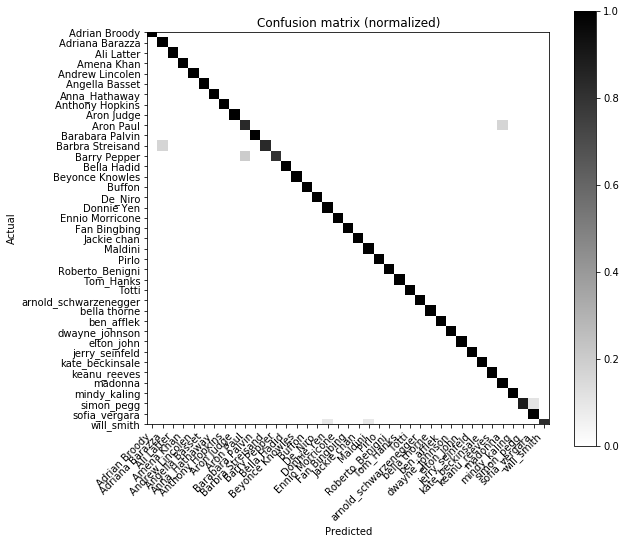

In [12]:
cm = ConfusionMatrix(testy, yhat_test)
cm.plot(normalized=True)
plt.show()

# Plot the learning curve 

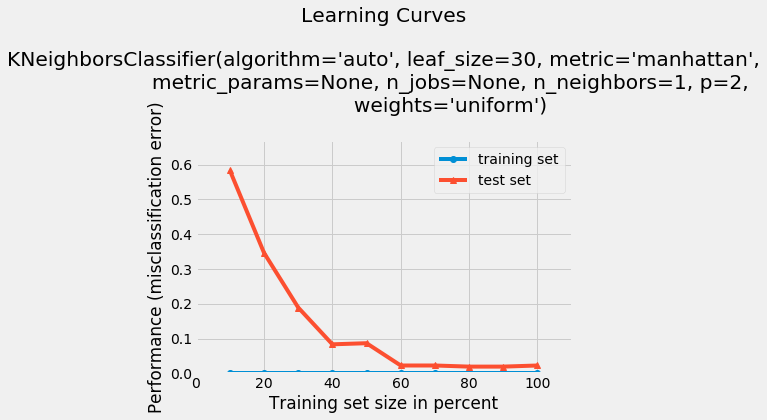

In [13]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
plot_learning_curves(trainX_e, trainy, testX_e, testy, neigh)
plt.show()

# Now for the SVC classifier 

# Tuning the hyper parameters to chooes the best ones 

In [14]:
# example of grid searching key hyperparametres for SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50,10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(trainX_e, trainy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best: 0.983974 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.971154 (0.026647) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.977564 (0.023924) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.977564 (0.025329) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.971154 (0.026647) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.977564 (0.023924) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.977564 (0.025329) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.971154 (0.026647) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.977564 (0.023924) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.983974 (0.019826) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.044872 (0.014951) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.051282 (0.020529) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.222222 (0.047258) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.044872 (0.014951) with: {'C': 0.01, 'gamma': 'sca

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
svc =SVC(C=1.0, gamma='scale', kernel='sigmoid')
svc.fit(trainX_e, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Printing the classification report and the accuracy 

In [16]:
yhat_train = svc.predict(trainX_e)
yhat_test = svc.predict(testX_e)  
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
report = classification_report(testy, yhat_test)
matrics = confusion_matrix(testy,yhat_test)
print(report)
print('Accuracy SVM : train=%.3f, test=%.3f' % (score_train*100, score_test*100))

                       precision    recall  f1-score   support

        Adrian Broody       1.00      1.00      1.00        10
      Adriana Barazza       1.00      1.00      1.00        11
           Ali Latter       1.00      1.00      1.00         5
           Amena Khan       1.00      1.00      1.00         8
      Andrew Lincolen       1.00      1.00      1.00        11
       Angella Basset       1.00      1.00      1.00        11
        Anna_Hathaway       1.00      1.00      1.00         5
      Anthony Hopkins       1.00      1.00      1.00         7
           Aron Judge       1.00      1.00      1.00         8
            Aron Paul       0.83      0.83      0.83         6
      Barabara Palvin       1.00      1.00      1.00         9
     Barbra Streisand       1.00      0.83      0.91         6
         Barry Pepper       1.00      0.90      0.95        10
          Bella Hadid       1.00      1.00      1.00         7
      Beyonce Knowles       1.00      1.00      1.00  

# Calculating the FP, FN, TP and TN

In [17]:
FP = matrics.sum(axis=0) - np.diag(matrics)  
FN = matrics.sum(axis=1) - np.diag(matrics)
TP = np.diag(matrics)
TN = matrics.sum() - (FP + FN + TP)
# cm = ConfusionMatrix(testy, yhat_test)
print('FP = ', sum(FP))
print('FN = ',sum(FN))
print('TP = ',sum(TP))
print('TN = ',sum(TN))


FP =  6
FN =  6
TP =  306
TN =  11850


# Ploting the confusion matrix 

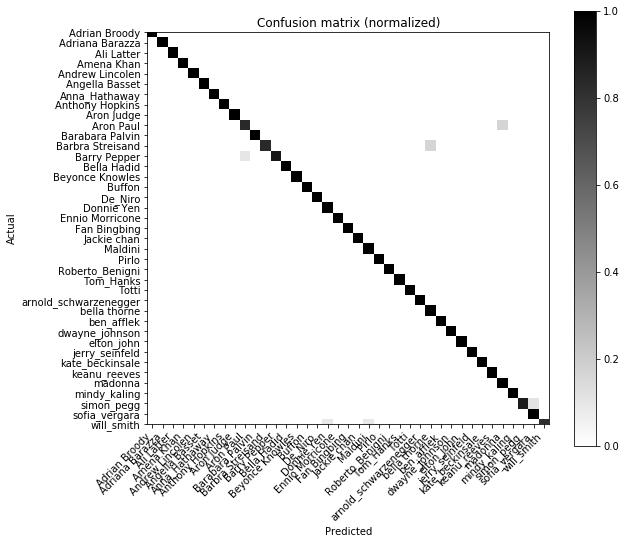

In [18]:
cm = ConfusionMatrix(testy, yhat_test)
cm.plot(normalized=True)
plt.show()

# Ploting the learning curve 

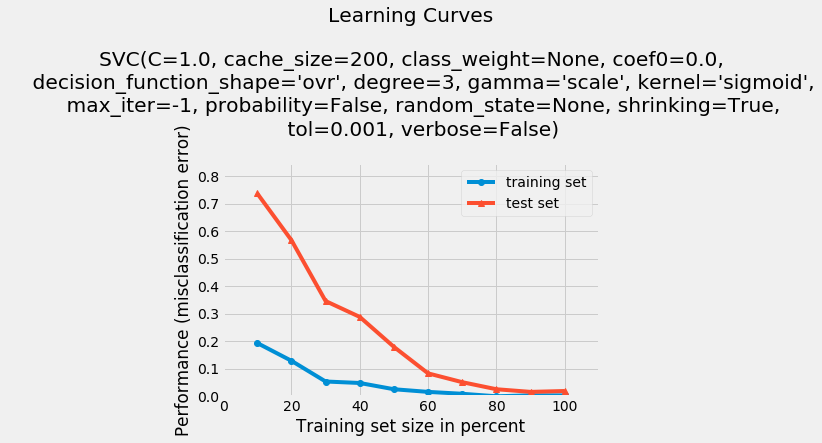

In [19]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
plot_learning_curves(trainX_e, trainy, testX_e, testy, svc)
plt.show()